In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install openslide-python
!apt-get install -y openslide-tools
# !pip install torch
!pip install torch torchvision

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 0 not upgraded.
Need to get 104 kB of archives.
After this operation, 297 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libopenslide0 amd64 3.4.1+dfsg-5build1 [89.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 openslide-tools amd64 3.4.1+dfsg-5build1 [13.8 kB]
Fetched 104 kB in 0s (496 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 119638 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-5build1_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-5build1) ...
Selecting previously unselected package openslide-tools.


## Patch Extraction from Whole Slide Images (WSIs)

This code processes Whole Slide Images (WSIs) in .svs format to extract smaller, uniform image patches for analysis. It reads slides from labeled folders (GBM_Images and LGG_Images), scales them to a specified resolution, and divides them into a grid of patches. Each patch is resized to maintain consistency and saved as .png files in organized subdirectories. Robust error handling ensures smooth processing, making the script effective for preparing histopathological data for machine learning workflows.

In [ ]:
import os
import openslide
from PIL import Image

def load_image_patches(input_folder, num_patches, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    label_mapping = {
        "GBM_Images": "gbm",
        "LGG_Images": "lgg"
    }

    for folder_name, label in label_mapping.items():
        folder_path = os.path.join(input_folder, folder_name)
        label_output_folder = os.path.join(output_folder, folder_name)
        os.makedirs(label_output_folder, exist_ok=True)

        for filename in os.listdir(folder_path):
            if filename.endswith(".svs"):
                path = os.path.join(folder_path, filename)
                try:
                    slide = openslide.OpenSlide(path)
                except Exception as e:
                    print(f"Error opening file {filename}: {e}")
                    continue

                level = 1
                base_width, base_height = slide.level_dimensions[0]
                level_width, level_height = slide.level_dimensions[level]
                scaling_factor = base_width / level_width

                print(f"Processing {filename} at level {level}, dimensions: {level_width}x{level_height}")

                patch_width = level_width // num_patches
                patch_height = level_height // num_patches

                slide_base_name = os.path.splitext(filename)[0]
                image_output_folder = os.path.join(label_output_folder, slide_base_name)
                os.makedirs(image_output_folder, exist_ok=True)

                cnt = 0
                for i in range(num_patches):
                    for j in range(num_patches):
                        left = j * patch_width
                        top = i * patch_height
                        current_patch_width = patch_width if j < num_patches - 1 else level_width - left
                        current_patch_height = patch_height if i < num_patches - 1 else level_height - top

                        # Adjust coordinates for base level
                        base_left = int(left * scaling_factor)
                        base_top = int(top * scaling_factor)

                        # print(f"Patch {cnt + 1}: Base-Location=({base_left}, {base_top}), "
                        #       f"Size=({current_patch_width}x{current_patch_height})")

                        try:
                            patch = slide.read_region(
                                location=(base_left, base_top),
                                level=level,
                                size=(current_patch_width, current_patch_height)
                            )
                            patch = patch.convert("RGB")

                            # Resize patch if it is smaller than standard size
                            if current_patch_width != patch_width or current_patch_height != patch_height:
                                patch = patch.resize((patch_width, patch_height), Image.Resampling.LANCZOS)

                            patch_filename = f"{slide_base_name}_patch_{cnt + 1}.png"
                            patch_filepath = os.path.join(image_output_folder, patch_filename)
                            patch.save(patch_filepath)
                            cnt += 1
                        except Exception as e:
                            print(f"Error generating patch {cnt + 1}: {e}")
                            continue

                print(f"Completed {cnt} patches for {filename}")


## Patch Extraction for Training Slides

In [ ]:
input_folder = "/content/drive/MyDrive/Open Slide Images Dataset/Training/Training_Images"
output_folder = "/content/drive/MyDrive/Open Slide Images Dataset/Training/Training_Patches"

num_patches = 5
load_image_patches(input_folder, num_patches, output_folder)


Processing gbm_slide_105.svs at level 1, dimensions: 17000x9352
Completed 25 patches for gbm_slide_105.svs
Processing gbm_slide_112.svs at level 1, dimensions: 16979x11135
Completed 25 patches for gbm_slide_112.svs
Processing gbm_slide_113.svs at level 1, dimensions: 13430x9709
Completed 25 patches for gbm_slide_113.svs
Processing gbm_slide_114.svs at level 1, dimensions: 10792x9406
Completed 25 patches for gbm_slide_114.svs
Processing gbm_slide_115.svs at level 1, dimensions: 21912x18148
Completed 25 patches for gbm_slide_115.svs
Processing gbm_slide_116.svs at level 1, dimensions: 21824x8123
Completed 25 patches for gbm_slide_116.svs
Processing gbm_slide_117.svs at level 1, dimensions: 10000x9710
Completed 25 patches for gbm_slide_117.svs
Processing gbm_slide_101.svs at level 1, dimensions: 13500x9992
Completed 25 patches for gbm_slide_101.svs
Processing gbm_slide_102.svs at level 1, dimensions: 11500x9371
Completed 25 patches for gbm_slide_102.svs
Processing gbm_slide_103.svs at lev

## Patch Extraction for Testing Slides

In [ ]:
input_folder = "/content/drive/MyDrive/Open Slide Images Dataset/Testing/Testing_Images"
output_folder = "/content/drive/MyDrive/Open Slide Images Dataset/Testing/Testing_Patches"

num_patches = 5
load_image_patches(input_folder, num_patches, output_folder)


Processing gbm_slide_1.svs at level 1, dimensions: 29206x19314
Completed 25 patches for gbm_slide_1.svs
Processing gbm_slide_2.svs at level 1, dimensions: 21824x8123
Completed 25 patches for gbm_slide_2.svs
Processing gbm_slide_3.svs at level 1, dimensions: 15980x11447
Completed 25 patches for gbm_slide_3.svs
Processing gbm_slide_4.svs at level 1, dimensions: 17000x10089
Completed 25 patches for gbm_slide_4.svs
Processing gbm_slide_5.svs at level 1, dimensions: 25397x19961
Completed 25 patches for gbm_slide_5.svs
Processing gbm_slide_6.svs at level 1, dimensions: 28883x21978
Completed 25 patches for gbm_slide_6.svs
Processing gbm_slide_7.svs at level 1, dimensions: 19919x14443
Completed 25 patches for gbm_slide_7.svs
Processing gbm_slide_8.svs at level 1, dimensions: 20417x15816
Completed 25 patches for gbm_slide_8.svs
Processing gbm_slide_9.svs at level 1, dimensions: 43325x14628
Completed 25 patches for gbm_slide_9.svs
Processing gbm_slide_10.svs at level 1, dimensions: 36852x20390
C

## White Patch Filtering for Histopathological Image Patches

This script filters out predominantly white patches from a dataset of histopathological images while preserving the folder structure. It recursively processes image files (.png, .jpg, .jpeg) in a given input directory, calculates the fraction of white pixels in each patch, and discards patches exceeding a specified white pixel threshold. Non-white patches are saved to the output directory, maintaining their relative paths. The script also logs discarded patches slide-wise, including their names and white pixel fractions, for transparency. This ensures a clean dataset with meaningful tissue content for downstream analysis.

In [ ]:
import cv2
import numpy as np
import os
from collections import defaultdict

def filter_white_patches_recursive(input_folder, output_folder, intensity_threshold=200, white_threshold=0.9):
    """
    Filters out patches that are predominantly white, preserving directory structure.
    Prints discarded patches slide-wise as they are processed.

    Args:
    - input_folder (str): Path to the folder containing the patches (including subdirectories).
    - output_folder (str): Path to save the filtered patches (preserves subdirectory structure).
    - intensity_threshold (int): Pixel intensity threshold to consider as "white" (default: 200).
    - white_threshold (float): Fraction of pixels above intensity_threshold to mark a patch as "white" (default: 0.9).
    """
    for root, dirs, files in os.walk(input_folder):
        discarded_patches = []  # Store discarded patches for the current slide

        for file in files:
            if file.endswith((".png", ".jpg", ".jpeg")):  # Process only image files
                input_path = os.path.join(root, file)
                # Derive the relative path to preserve the directory structure
                relative_path = os.path.relpath(input_path, input_folder)
                output_path = os.path.join(output_folder, relative_path)

                # Create the output directory if it doesn't exist
                os.makedirs(os.path.dirname(output_path), exist_ok=True)

                # Read the patch
                patch = cv2.imread(input_path)
                if patch is None:
                    print(f"Warning: Could not read {input_path}. Skipping.")
                    continue

                # Check the number of white pixels
                total_pixels = patch.shape[0] * patch.shape[1]
                white_pixels = np.sum(np.all(patch > intensity_threshold, axis=2))  # Check all channels > threshold

                # Calculate the white pixel fraction
                white_fraction = white_pixels / total_pixels

                # Save patches that are not predominantly white
                if white_fraction < white_threshold:
                    cv2.imwrite(output_path, patch)
                else:
                    # Store discarded patches for the current slide
                    patch_name = file.replace(".png", "").replace(".jpg", "").replace(".jpeg", "")  # Remove extension
                    discarded_patches.append((patch_name, white_fraction))

        # Print the results for the current slide
        if discarded_patches:
            slide_name = os.path.basename(root)  # Extract the slide name (parent folder)
            print(f"\nDiscarded patches from {slide_name}:")
            for patch_name, white_fraction in discarded_patches:
                print(f"{patch_name} (white fraction: {white_fraction:.2f})")


## White Patch Filtering for Training patches

In [ ]:
input_folder  = "/content/drive/MyDrive/Open Slide Images Dataset/Training/Training_Patches"
output_folder = "/content/drive/MyDrive/Open Slide Images Dataset/Training/Training_Patches_Filtered"
filter_white_patches_recursive(input_folder, output_folder, intensity_threshold=200, white_threshold=0.85)



Discarded patches from lgg_slide_106:
lgg_slide_106_patch_2 (white fraction: 0.92)
lgg_slide_106_patch_3 (white fraction: 1.00)
lgg_slide_106_patch_4 (white fraction: 0.90)
lgg_slide_106_patch_5 (white fraction: 0.99)
lgg_slide_106_patch_8 (white fraction: 1.00)
lgg_slide_106_patch_13 (white fraction: 1.00)
lgg_slide_106_patch_16 (white fraction: 0.92)
lgg_slide_106_patch_18 (white fraction: 1.00)
lgg_slide_106_patch_21 (white fraction: 0.98)
lgg_slide_106_patch_23 (white fraction: 1.00)
lgg_slide_106_patch_24 (white fraction: 0.97)

Discarded patches from lgg_slide_101:
lgg_slide_101_patch_1 (white fraction: 1.00)
lgg_slide_101_patch_5 (white fraction: 1.00)
lgg_slide_101_patch_6 (white fraction: 0.97)
lgg_slide_101_patch_10 (white fraction: 1.00)
lgg_slide_101_patch_21 (white fraction: 0.86)
lgg_slide_101_patch_23 (white fraction: 0.92)
lgg_slide_101_patch_24 (white fraction: 0.87)
lgg_slide_101_patch_25 (white fraction: 0.89)

Discarded patches from lgg_slide_102:
lgg_slide_102_pat

## White Patch Filtering for Testing patches

In [ ]:
input_folder  = "/content/drive/MyDrive/Open Slide Images Dataset/Testing/Testing_Patches"
output_folder = "/content/drive/MyDrive/Open Slide Images Dataset/Testing/Testing_Patches_Filtered"
filter_white_patches_recursive(input_folder, output_folder, intensity_threshold=200, white_threshold=0.85)



Discarded patches from lgg_slide_1:
lgg_slide_1_patch_1 (white fraction: 1.00)
lgg_slide_1_patch_2 (white fraction: 1.00)
lgg_slide_1_patch_5 (white fraction: 0.93)
lgg_slide_1_patch_6 (white fraction: 1.00)
lgg_slide_1_patch_24 (white fraction: 0.98)
lgg_slide_1_patch_25 (white fraction: 1.00)

Discarded patches from lgg_slide_2:
lgg_slide_2_patch_1 (white fraction: 0.91)
lgg_slide_2_patch_5 (white fraction: 0.96)
lgg_slide_2_patch_6 (white fraction: 0.98)
lgg_slide_2_patch_10 (white fraction: 0.91)
lgg_slide_2_patch_20 (white fraction: 0.93)
lgg_slide_2_patch_21 (white fraction: 1.00)
lgg_slide_2_patch_22 (white fraction: 0.90)
lgg_slide_2_patch_25 (white fraction: 1.00)

Discarded patches from lgg_slide_3:
lgg_slide_3_patch_1 (white fraction: 0.99)
lgg_slide_3_patch_2 (white fraction: 1.00)
lgg_slide_3_patch_3 (white fraction: 1.00)
lgg_slide_3_patch_4 (white fraction: 0.89)
lgg_slide_3_patch_6 (white fraction: 1.00)
lgg_slide_3_patch_11 (white fraction: 0.95)
lgg_slide_3_patch_16 

## Slide Patch Feature Extraction Using KimiaNet model

This code extracts deep features from patches of histopathological slides using a DenseNet121-based model. It is designed to process a single slide folder, compute features for each patch, and save the results as a pickle file for downstream analysis.



### Code on complete training and testing folders - Each file

In [ ]:
from __future__ import print_function, division

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset, DataLoader
from glob import glob
from skimage import io, transform
import torch.nn.functional as F
from PIL import Image
import pickle

plt.ion()  # Interactive mode

# Set up the device for GPU use if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Transformation pipeline
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Custom dataset loader to load image patches
class My_dataloader(Dataset):
    def __init__(self, data_folder, transform):
        """
        Args:
            data_folder: path to the folder containing the patches for a slide
        """
        print(f"Initializing dataset for folder: {data_folder}")
        self.data_folder = data_folder
        self.image_paths = glob(os.path.join(self.data_folder, '*'))  # Get all image paths
        self.transform = transform
        print(f"Found {len(self.image_paths)} images in {data_folder} \n")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')  # Open image and convert to RGB
        img_name = os.path.basename(self.image_paths[idx])  # Get image file name
        folder_name = os.path.basename(os.path.dirname(self.image_paths[idx]))  # Get folder name (slide name)

        if self.transform:

            img = self.transform(img)  # Apply transformations

        return img, img_name, folder_name

# Function to evaluate the model and generate features for a single slide
def test_model_single_slide(model, criterion, slide_folder, save_folder):
    since = time.time()
    model.eval()  # Set model to evaluation mode

    slide_patches_dict = {}

    # Use the slide folder name for naming the pickle file
    slide_name = os.path.basename(slide_folder)  # e.g., 'gbm_slide_1'
    print(f"Processing slide: {slide_name} \n")

    # Create a dataset and dataloader for the current slide
    test_dataset = My_dataloader(slide_folder, trans)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)
    print(f"Created DataLoader for {slide_name}. Batch size: 16 \n")

    # Iterate through the data in batches
    print("Iterating through batches...")
    for batch_idx, (inputs, img_name, folder_name) in enumerate(test_loader):
        print(f"Processing batch {batch_idx + 1}/{len(test_loader)}")
        inputs = inputs.to(device)

        # Forward pass through the model
        output1, outputs = model(inputs)
        output_features = output1.cpu().detach().numpy()  # Extracting the dense features

        # Store the features for each image patch
        for j in range(len(outputs)):
            slide_patches_dict[img_name[j]] = output_features[j]

    # Save the features as a pickle file with the slide name
    save_path = os.path.join(save_folder, slide_name + '_DenseNet121Features_dict.pickle')
    print(f"Saving features to {save_path}...")
    with open(save_path, 'wb') as outfile:
        pickle.dump(slide_patches_dict, outfile)

    print(f"Saved features for {slide_name} successfully. \n")

    # Time taken for evaluation
    time_elapsed = time.time() - since
    print('Evaluation completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

# Model definition: DenseNet121 with fully connected layers
class fully_connected(nn.Module):
    def __init__(self, model, num_ftrs, num_classes):
        super(fully_connected, self).__init__()
        self.model = model
        self.fc_4 = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = torch.flatten(x, 1)
        out_1 = x
        out_3 = self.fc_4(x)
        return out_1, out_3

# Load a pretrained DenseNet121 model
model = torchvision.models.densenet121(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.features = nn.Sequential(model.features, nn.AdaptiveAvgPool2d(output_size=(1, 1)))
num_ftrs = model.classifier.in_features
model_final = fully_connected(model.features, num_ftrs, 30)
model_final = nn.DataParallel(model_final)

# Load the pre-trained weights (replace with your actual path)
model_path = '/content/drive/MyDrive/Open Slide Images Dataset/KimiaNet/KimiaNet_Weights/weights/KimiaNetPyTorchWeights.pth'
print(f"Loading model weights from {model_path}...\n")

model_final.load_state_dict(torch.load(model_path, map_location=device))
model_final = model_final.to(device)

# Define the loss criterion
criterion = nn.CrossEntropyLoss()

# Specify the path to a single slide folder
slide_folder = '/content/drive/MyDrive/Open Slide Images Dataset/Training/Training_Patches_Filtered/GBM_Images/gbm_slide_110'
save_folder = '/content/drive/MyDrive/Open Slide Images Dataset/Training/Training_Pickle_Files'

# slide_folder = '/content/drive/MyDrive/Open Slide Images Dataset/Testing/Testing_Patches_Filtered/GBM_Images/gbm_slide_101'
# save_folder = '/content/drive/MyDrive/Open Slide Images Dataset/Testing/Testing_Pickle_Files'

# Ensure save folder exists
os.makedirs(save_folder, exist_ok=True)
print(f"Save folder: {save_folder} \n")

# Run the evaluation for the single slide
print("Starting evaluation for single slide...")
test_model_single_slide(model_final, criterion, slide_folder, save_folder)


Loading model weights from /content/drive/MyDrive/Open Slide Images Dataset/KimiaNet/KimiaNet_Weights/weights/KimiaNetPyTorchWeights.pth...

Save folder: /content/drive/MyDrive/Open Slide Images Dataset/Training/Training_Pickle_Files 

Starting evaluation for single slide...
Processing slide: gbm_slide_110 

Initializing dataset for folder: /content/drive/MyDrive/Open Slide Images Dataset/Training/Training_Patches_Filtered/GBM_Images/gbm_slide_110
Found 25 images in /content/drive/MyDrive/Open Slide Images Dataset/Training/Training_Patches_Filtered/GBM_Images/gbm_slide_110 

Created DataLoader for gbm_slide_110. Batch size: 16 

Iterating through batches...
Processing batch 1/2
Processing batch 2/2
Saving features to /content/drive/MyDrive/Open Slide Images Dataset/Training/Training_Pickle_Files/gbm_slide_110_DenseNet121Features_dict.pickle...
Saved features for gbm_slide_110 successfully. 

Evaluation completed in 11m 48s


## Code on complete training and testing folders - directly

In [ ]:
from __future__ import print_function, division

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset, DataLoader
from glob import glob
from skimage import io, transform
import torch.nn.functional as F
from PIL import Image
import pickle

plt.ion()  # Interactive mode

# Set up the device for GPU use if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Transformation pipeline
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Custom dataset loader to load image patches
class My_dataloader(Dataset):
    def __init__(self, data_folder, transform):
        """
        Args:
            data_folder: path to the folder containing the patches for a slide
        """
        print(f"Initializing dataset for folder: {data_folder}")
        self.data_folder = data_folder
        self.image_paths = glob(os.path.join(self.data_folder, '*'))  # Get all image paths
        self.transform = transform
        print(f"Found {len(self.image_paths)} images in {data_folder} \n")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')  # Open image and convert to RGB
        img_name = os.path.basename(self.image_paths[idx])  # Get image file name
        folder_name = os.path.basename(os.path.dirname(self.image_paths[idx]))  # Get folder name (slide name)

        if self.transform:
            img = self.transform(img)  # Apply transformations

        return img, img_name, folder_name

# Function to evaluate the model and generate features for a single slide
def test_model_single_slide(model, criterion, slide_folder, save_folder):
    since = time.time()
    model.eval()  # Set model to evaluation mode

    slide_patches_dict = {}

    # Use the slide folder name for naming the pickle file
    slide_name = os.path.basename(slide_folder)  # e.g., 'gbm_slide_1'
    print(f"Processing slide: {slide_name} \n")

    # Create a dataset and dataloader for the current slide
    test_dataset = My_dataloader(slide_folder, trans)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)
    print(f"Created DataLoader for {slide_name}. Batch size: 16 \n")

    # Iterate through the data in batches
    print("Iterating through batches...")
    for batch_idx, (inputs, img_name, folder_name) in enumerate(test_loader):
        print(f"Processing batch {batch_idx + 1}/{len(test_loader)}")
        inputs = inputs.to(device)

        # Forward pass through the model
        output1, outputs = model(inputs)
        output_features = output1.cpu().detach().numpy()  # Extracting the dense features

        # Store the features for each image patch
        for j in range(len(outputs)):
            slide_patches_dict[img_name[j]] = output_features[j]

    # Save the features as a pickle file with the slide name
    save_path = os.path.join(save_folder, slide_name + '_DenseNet121Features_dict.pickle')
    print(f"Saving features to {save_path}...")
    with open(save_path, 'wb') as outfile:
        pickle.dump(slide_patches_dict, outfile)

    print(f"Saved features for {slide_name} successfully. \n")

    # Time taken for evaluation
    time_elapsed = time.time() - since
    print('Evaluation completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

# Recursive function to process all slide folders
def process_all_slides(model, criterion, input_folder, output_folder):
    """
    Process all slide folders in the input directory.
    """
    for root, dirs, files in os.walk(input_folder):
        # Only process directories that contain image files
        if any(file.endswith(('.png', '.jpg', '.jpeg')) for file in files):
            slide_folder = root
            print(f"Processing slide folder: {slide_folder}")
            # Create corresponding output folder
            os.makedirs(output_folder, exist_ok=True)
            test_model_single_slide(model, criterion, slide_folder, output_folder)

# Model definition: DenseNet121 with fully connected layers
class fully_connected(nn.Module):
    def __init__(self, model, num_ftrs, num_classes):
        super(fully_connected, self).__init__()
        self.model = model
        self.fc_4 = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = torch.flatten(x, 1)
        out_1 = x
        out_3 = self.fc_4(x)
        return out_1, out_3

# Load a pretrained DenseNet121 model
model = torchvision.models.densenet121(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.features = nn.Sequential(model.features, nn.AdaptiveAvgPool2d(output_size=(1, 1)))
num_ftrs = model.classifier.in_features
model_final = fully_connected(model.features, num_ftrs, 30)
model_final = nn.DataParallel(model_final)

# Load the pre-trained weights (replace with your actual path)
model_path = '/content/drive/MyDrive/KimiaNet/KimiaNet_Weights/weights/KimiaNetPyTorchWeights.pth'
print(f"Loading model weights from {model_path}...\n")

model_final.load_state_dict(torch.load(model_path, map_location=device))
model_final = model_final.to(device)

# Define the loss criterion
criterion = nn.CrossEntropyLoss()

# Input and output folder paths
# input_folder = '/content/drive/MyDrive/Open Slide Images Dataset/Training/Training_Patches_Filtered'
# output_folder = '/content/drive/MyDrive/Open Slide Images Dataset/Training/Training_Pickle_Files'

input_folder = '/content/drive/MyDrive/Open Slide Images Dataset/Testing/Testing_Patches_Filtered'
output_folder = '/content/drive/MyDrive/Open Slide Images Dataset/Testing/Testing_Pickle_Files'

# Ensure save folder exists
os.makedirs(output_folder, exist_ok=True)

# Process all slides
print("Starting evaluation for all slides...")
process_all_slides(model_final, criterion, input_folder, output_folder)


## Loading Patch Features and Labels from Pickle Files

This script processes pre-extracted feature files stored as pickle dictionaries, consolidating them into datasets for training and testing. It is designed to handle features extracted from histopathological slide patches, associating them with corresponding labels and image identifiers.



In [ ]:
import pickle
import os
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Function to load all patches from pickle files
def load_patches(folder_path):
    data = []
    labels = []
    image_names = []  # To store simplified image names

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.pickle'):
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'rb') as f:
                slide_patches_dict = pickle.load(f)  # Load the dictionary containing patches and features

                # Collect all feature vectors from the dictionary
                for patch_name, feature_vector in slide_patches_dict.items():
                    data.append(feature_vector)

                    # Store only the simplified image name (e.g., 'gbm_slide_3')
                    simplified_name = '_'.join(file_name.split('_')[:3])  # Assuming the first three parts form the unique identifier
                    image_names.append(simplified_name)

                    # Store only 'gbm' or 'lgg' based on the filename
                    if 'gbm' in file_name:
                        labels.append(1)  # GBM class
                    elif 'lgg' in file_name:
                        labels.append(0)  # LGG class

    return np.array(data), np.array(labels), image_names

# Load training and testing data
train_folder = '/content/drive/MyDrive/Open Slide Images Dataset/Results - dataset_50_level_1/Training_Pickle_Files'
test_folder = '/content/drive/MyDrive/Open Slide Images Dataset/Results - dataset_50_level_1/Testing_Pickle_Files'

X_train, y_train, train_image_names = load_patches(train_folder)
X_test, y_test, test_image_names = load_patches(test_folder)

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing data shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)
print()
print("Training Image names:", train_image_names)
print("Testing Image names:", test_image_names)

Training data shape: (780, 1024)
Training labels shape: (780,)
Testing data shape: (307, 1024)
Testing labels shape: (307,)

Training Image names: ['gbm_slide_101', 'gbm_slide_101', 'gbm_slide_101', 'gbm_slide_101', 'gbm_slide_101', 'gbm_slide_101', 'gbm_slide_101', 'gbm_slide_101', 'gbm_slide_101', 'gbm_slide_101', 'gbm_slide_101', 'gbm_slide_101', 'gbm_slide_101', 'gbm_slide_101', 'gbm_slide_101', 'gbm_slide_101', 'gbm_slide_101', 'gbm_slide_101', 'gbm_slide_101', 'gbm_slide_101', 'gbm_slide_101', 'gbm_slide_101', 'gbm_slide_102', 'gbm_slide_102', 'gbm_slide_102', 'gbm_slide_102', 'gbm_slide_102', 'gbm_slide_102', 'gbm_slide_102', 'gbm_slide_102', 'gbm_slide_102', 'gbm_slide_102', 'gbm_slide_102', 'gbm_slide_102', 'gbm_slide_102', 'gbm_slide_102', 'gbm_slide_102', 'gbm_slide_102', 'gbm_slide_102', 'gbm_slide_102', 'gbm_slide_102', 'gbm_slide_102', 'gbm_slide_102', 'gbm_slide_102', 'gbm_slide_102', 'gbm_slide_102', 'gbm_slide_103', 'gbm_slide_103', 'gbm_slide_103', 'gbm_slide_103', 'g

## t-SNE Visualization for High-Dimensional Data

This script visualizes high-dimensional data (e.g., extracted features from histopathological patches) using t-SNE, a dimensionality reduction technique that projects data into a 2D space for easier interpretation.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_tsne(X, y, title, fig_width, fig_height):
    # Perform t-SNE with 2 components for visualization
    tsne = TSNE(n_components=2, perplexity=15, random_state=42)
    X_tsne = tsne.fit_transform(X)

    # Plot t-SNE results
    plt.figure(figsize=(fig_width, fig_height))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, ticks=[0, 1], label="Class")
    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(True)
    plt.show()


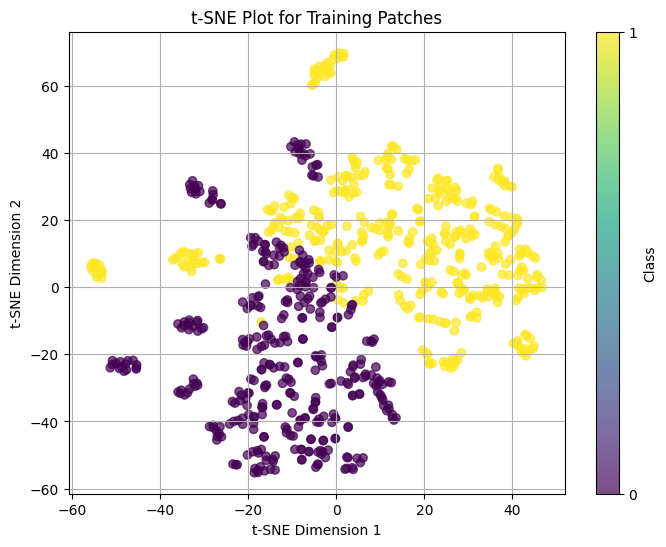

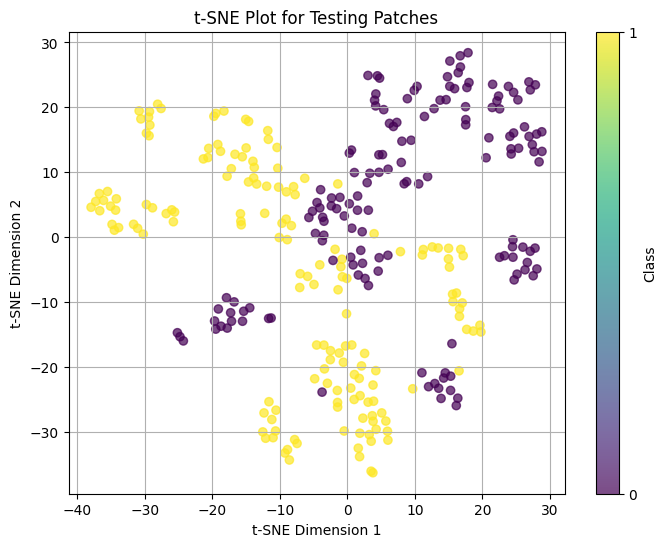

In [ ]:
# Plot t-SNE for training and testing data with specific figure size
plot_tsne(X_train, y_train, title="t-SNE Plot for Training Patches", fig_width=8, fig_height=6)
print()
plot_tsne(X_test, y_test, title="t-SNE Plot for Testing Patches", fig_width=8, fig_height=6)


## Patch wise Feature Classifcation Results

## Training Data

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the classifier on the validation set
y_val_pred = clf.predict(X_train)
print(y_val_pred)
print("Validation Accuracy:", accuracy_score(y_train, y_val_pred))
print(classification_report(y_train, y_val_pred))


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

## Testing Data

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# best_params = random_search.best_params_
best_params = {'subsample': 1.0, 'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.8}
clf = XGBClassifier(
    **best_params,  # Unpack the best parameters
    eval_metric='logloss',  # Add other required parameters not tuned
    use_label_encoder=False,
    random_state=42
)
clf.fit(X_train, y_train)

# Evaluate the classifier on the validation set
y_val_pred = clf.predict(X_test)
print(y_val_pred)
print("Validation Accuracy:", accuracy_score(y_test, y_val_pred))
print(classification_report(y_test, y_val_pred))


[0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0]
Validation Accuracy: 0.6970684039087948
              precision    recall  f1-score   support

           0       0.65      0.82      0.72       148
           1       0.78      0.58      0.67       159

    accuracy                           0.70       307
   macro avg       0.71      0.70      0.69       307
weighted avg       0.71      0.70      0.69       307



## Evaluating the Classifier with Training Data

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier with the best parameters
best_params = {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}

clf = RandomForestClassifier(
    **best_params,
    random_state=42
)

# Train the classifier
clf.fit(X_train, y_train)

# Predict on the selected test data (patch-level)
y_train_patch_pred = clf.predict(X_train)

# Function to calculate image-level predictions and statistics
def calculate_image_predictions(train_image_names, y_train_patch_pred):
    image_patch_stats = {}
    image_level_labels = []  # Slide-level predictions
    ground_truth_labels = []

    # Aggregate patch predictions by image
    unique_images = list(set(train_image_names))
    unique_images.sort()

    for image_name in unique_images:
        # Get all patches for the current image
        indices = [i for i, name in enumerate(train_image_names) if name == image_name]
        patch_predictions = y_train_patch_pred[indices]

        # Calculate statistics
        total_patches = len(patch_predictions)
        gbm_count = sum(patch_predictions)
        lgg_count = total_patches - gbm_count

        # Determine image-level label (majority vote)
        image_label = 1 if gbm_count > lgg_count else 0
        image_level_labels.append(image_label)

        # Append true label based on the naming convention
        true_label = 1 if "gbm" in image_name else 0
        ground_truth_labels.append(true_label)

        # Store stats
        image_patch_stats[image_name] = {
            "total_patches": total_patches,
            "lgg_count": lgg_count,
            "gbm_count": gbm_count,
            "label": "gbm" if image_label == 1 else "lgg",
        }

    return image_patch_stats, image_level_labels, ground_truth_labels

# Calculate patch-wise statistics and image-level predictions
image_patch_stats, image_level_predictions, ground_truth_labels = calculate_image_predictions(train_image_names, y_train_patch_pred)

# Print patch-wise statistics
print("\nPatch-wise predictions:")
for image, stats in image_patch_stats.items():
    print(f"{image}: total: {stats['total_patches']}, lgg: {stats['lgg_count']}, gbm: {stats['gbm_count']}, label: {stats['label']}")

# Calculate slide-level accuracy
slide_accuracy = accuracy_score(ground_truth_labels, image_level_predictions)
print(f"\nTrain Accuracy (Slide-Level): {slide_accuracy:.4f}")

# Generate classification report
print("\nClassification Report (Slide-Level):")
print(classification_report(ground_truth_labels, image_level_predictions, target_names=["LGG", "GBM"]))




Patch-wise predictions:
gbm_slide_101: total: 22, lgg: 0, gbm: 22, label: gbm
gbm_slide_102: total: 24, lgg: 0, gbm: 24, label: gbm
gbm_slide_103: total: 23, lgg: 0, gbm: 23, label: gbm
gbm_slide_104: total: 22, lgg: 0, gbm: 22, label: gbm
gbm_slide_105: total: 19, lgg: 0, gbm: 19, label: gbm
gbm_slide_106: total: 21, lgg: 0, gbm: 21, label: gbm
gbm_slide_107: total: 24, lgg: 0, gbm: 24, label: gbm
gbm_slide_108: total: 19, lgg: 0, gbm: 19, label: gbm
gbm_slide_109: total: 24, lgg: 0, gbm: 24, label: gbm
gbm_slide_110: total: 25, lgg: 0, gbm: 25, label: gbm
gbm_slide_111: total: 23, lgg: 0, gbm: 23, label: gbm
gbm_slide_112: total: 24, lgg: 0, gbm: 24, label: gbm
gbm_slide_113: total: 23, lgg: 0, gbm: 23, label: gbm
gbm_slide_114: total: 20, lgg: 0, gbm: 20, label: gbm
gbm_slide_115: total: 24, lgg: 0, gbm: 24, label: gbm
gbm_slide_116: total: 24, lgg: 0, gbm: 24, label: gbm
gbm_slide_117: total: 23, lgg: 0, gbm: 23, label: gbm
gbm_slide_118: total: 24, lgg: 0, gbm: 24, label: gbm
lgg

## Training the Classifier

## XGB Classifier with Random Search CV for Hypertuning parameters

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Define hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.01, 0.1, 1, 10]
}

# Initialize the classifier
clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# RandomizedSearchCV setup
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=50,  # Number of combinations to try
    scoring='accuracy',  # Change based on your task
    cv=3,  # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the search
random_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Hyperparameters: {'subsample': 1.0, 'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.8}


In [ ]:
from xgboost import XGBClassifier

# best_params = random_search.best_params_
best_params = {'subsample': 1.0, 'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.8}
clf = XGBClassifier(
    **best_params,  # Unpack the best parameters
    eval_metric='logloss',  # Add other required parameters not tuned
    use_label_encoder=False,
    random_state=42
)

# clf = XGBClassifier(n_estimators=100, eval_metric='logloss',  use_label_encoder=False, random_state=42);

# Train the classifier
clf.fit(X_train, y_train)

# Predict on the selected test data (patch-level)
y_test_patch_pred = clf.predict(X_test)

## Gradient Boosting Classifier with Random Search CV for Hypertuning parameters

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize the classifier
gbc = GradientBoostingClassifier(random_state=42)

# Set up the RandomizedSearchCV
random_search_gbc = RandomizedSearchCV(
    estimator=gbc,
    param_distributions=param_dist,
    n_iter=50,  # Number of random configurations to try
    scoring='accuracy',  # Adjust to a relevant metric for your problem
    cv=3,  # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the search to the data
random_search_gbc.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", random_search_gbc.best_params_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 4, 'learning_rate': 0.2}


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# best_params = random_search_gbc.best_params_
best_params = {'subsample': 0.8, 'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 4, 'learning_rate': 0.2}

clf = GradientBoostingClassifier(
    **best_params,  # Unpack the best parameters
    random_state=42
)

# clf = GradientBoostingClassifier(n_estimators=200, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Predict on the selected test data (patch-level)
y_test_patch_pred = clf.predict(X_test)

## Random Forest Classifier with Random Search CV for Hypertuning parameters

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Initialize the RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)

# Set up RandomizedSearchCV
random_search_rfc = RandomizedSearchCV(
    estimator=rfc,
    param_distributions=param_dist,
    n_iter=50,  # Number of random combinations to try
    scoring='accuracy',  # Adjust metric to your problem (e.g., ROC-AUC, F1-score)
    cv=3,  # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the search to the data
random_search_rfc.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", random_search_rfc.best_params_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier with the best parameters
# best_params = random_search_rfc.best_params_
best_params = {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}

clf = RandomForestClassifier(
    **best_params,
    random_state=42
)

# clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Predict on the selected test data (patch-level)
y_test_patch_pred = clf.predict(X_test)

## Evaluating the classifier with Testing Data using Majority voting

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Function to calculate image-level predictions and statistics
def calculate_image_predictions(test_image_names, y_test_patch_pred):
    image_patch_stats = {}
    image_level_labels = []  # Slide-level predictions
    ground_truth_labels = []

    # Aggregate patch predictions by image
    unique_images = list(set(test_image_names))
    unique_images.sort()

    for image_name in unique_images:
        # Get all patches for the current image
        indices = [i for i, name in enumerate(test_image_names) if name == image_name]
        patch_predictions = y_test_patch_pred[indices]

        # Calculate statistics
        total_patches = len(patch_predictions)
        gbm_count = sum(patch_predictions)
        lgg_count = total_patches - gbm_count

        # Determine image-level label (majority vote)
        image_label = 1 if gbm_count > lgg_count else 0
        image_level_labels.append(image_label)

        # Append true label based on the naming convention
        true_label = 1 if "gbm" in image_name else 0
        ground_truth_labels.append(true_label)

        # Store stats
        image_patch_stats[image_name] = {
            "total_patches": total_patches,
            "lgg_count": lgg_count,
            "gbm_count": gbm_count,
            "label": "gbm" if image_label == 1 else "lgg",
        }

    return image_patch_stats, image_level_labels, ground_truth_labels

# Calculate patch-wise statistics and image-level predictions
image_patch_stats, image_level_predictions, ground_truth_labels = calculate_image_predictions(test_image_names, y_test_patch_pred)

# Print patch-wise statistics
print("\nPatch-wise predictions:")
for image, stats in image_patch_stats.items():
    print(f"{image}: total: {stats['total_patches']}, lgg: {stats['lgg_count']}, gbm: {stats['gbm_count']}, label: {stats['label']}")

# Calculate slide-level accuracy
slide_accuracy = accuracy_score(ground_truth_labels, image_level_predictions)
print(f"\nTest Accuracy (Slide-Level): {slide_accuracy:.4f}")

# Generate classification report
print("\nClassification Report (Slide-Level):")
print(classification_report(ground_truth_labels, image_level_predictions, target_names=["LGG", "GBM"]))



Patch-wise predictions:
gbm_slide_1: total: 22, lgg: 21, gbm: 1, label: lgg
gbm_slide_2: total: 24, lgg: 0, gbm: 24, label: gbm
gbm_slide_3: total: 23, lgg: 14, gbm: 9, label: lgg
gbm_slide_4: total: 22, lgg: 1, gbm: 21, label: gbm
gbm_slide_5: total: 24, lgg: 6, gbm: 18, label: gbm
gbm_slide_6: total: 23, lgg: 3, gbm: 20, label: gbm
gbm_slide_7: total: 21, lgg: 15, gbm: 6, label: lgg
lgg_slide_1: total: 21, lgg: 20, gbm: 1, label: lgg
lgg_slide_2: total: 23, lgg: 21, gbm: 2, label: lgg
lgg_slide_3: total: 19, lgg: 19, gbm: 0, label: lgg
lgg_slide_4: total: 21, lgg: 21, gbm: 0, label: lgg
lgg_slide_5: total: 23, lgg: 6, gbm: 17, label: gbm
lgg_slide_6: total: 22, lgg: 22, gbm: 0, label: lgg
lgg_slide_7: total: 23, lgg: 22, gbm: 1, label: lgg

Test Accuracy (Slide-Level): 0.7143

Classification Report (Slide-Level):
              precision    recall  f1-score   support

         LGG       0.67      0.86      0.75         7
         GBM       0.80      0.57      0.67         7

    accu